In [ ]:
import sys
sys.path.append('/your/project/path/')
import numpy as np
import time
import torch
from utils.registry import get_model
from utils import evaluators
import matplotlib.pyplot as plt
import numpy as np
from utils.dataset import imagenet, imagenet_fewshot
from utils.trainer import concept_awared_cutmix

device = 'cuda'
seed = 22

In [68]:
## 函数
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

def show_imagenet_images(images,save_path=None):
    num_images = images.shape[0]
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    denormalized_images = denormalize(images.clone(), mean, std)
    denormalized_images = denormalized_images.numpy().transpose((0, 2, 3, 1))
    denormalized_images = np.clip(denormalized_images, 0, 1)
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(denormalized_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    if save_path:
        for i in range(num_images):
            plt.imshow(denormalized_images[i])
            plt.axis('off')
            plt.savefig(f'{save_path}_{i}.png', bbox_inches='tight', pad_inches=0, dpi=600)
            plt.close()

In [ ]:
## load model
model = get_model('resnet34', 1000, 'imagenet', pretrained=True)
model = model.to(device).eval()

## load dataset
num_sample, batch_size, workers, imagenet_path,  = 2, 64, 8, '/your/dataset/path'
st = time.time()
sampled_loader = imagenet_fewshot(num_sample, batch_size, workers, seed, False, imagenet_path)
val_loader = imagenet(False, batch_size, workers, imagenet_path = imagenet_path)
et = time.time()
print('==> Load dataset success. Cost {:.2f}s'.format(et-st))

Full dataset has 1000 classes and 1281167 images.
Using seed=22 to sample images.
Final samples: 2
==> Load dataset success. Cost 1.04s


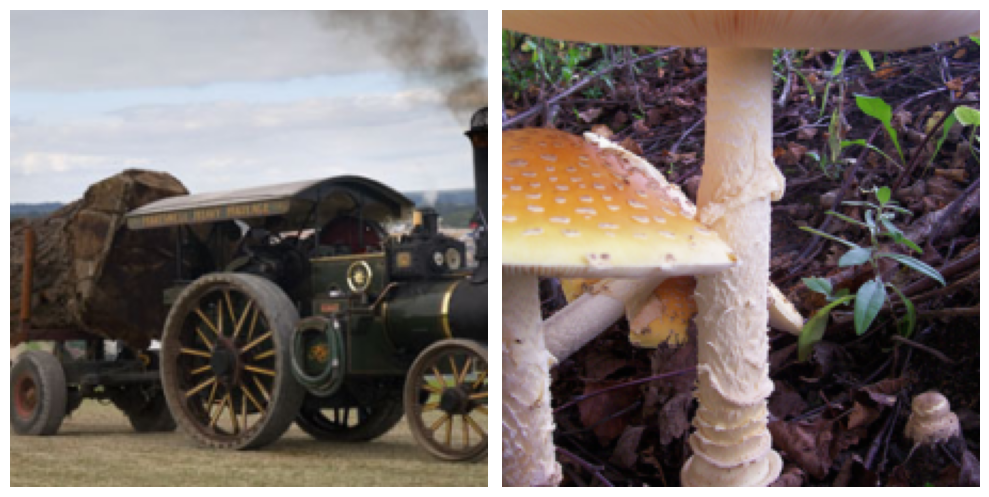

In [ ]:
## original images
for _, (images, _) in enumerate(sampled_loader):
    break
sp = 'figs/original_images'
show_imagenet_images(images,sp)

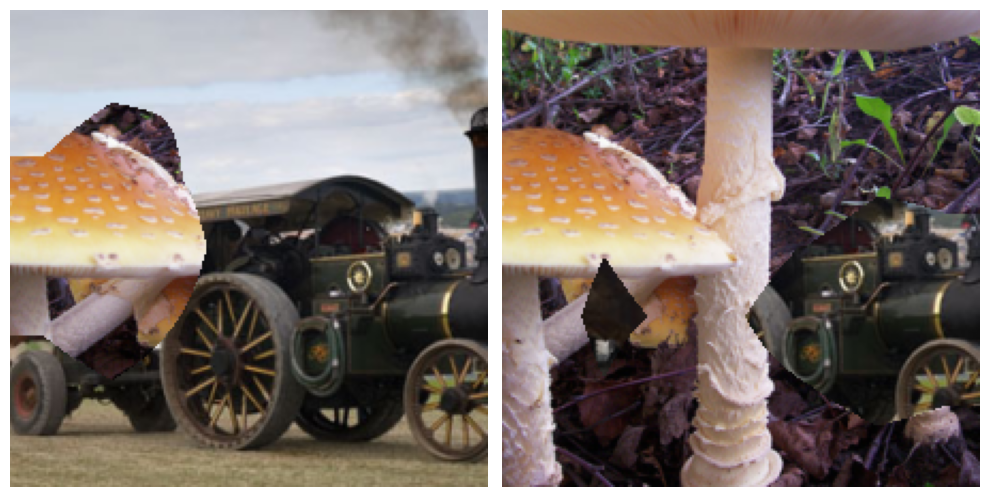

In [ ]:
## CMg
CMg_images = concept_awared_cutmix(images.to(device), 1, model, last_layer = True, mode = 'cover')
sp = 'figs/CMg_images'
show_imagenet_images(CMg_images.cpu(),sp)

In [79]:
def mixup(x, y = None, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)  # Random lambda from Beta distribution
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 2:
        index = torch.tensor([1,0])
    else:
        index = torch.randperm(batch_size).to(x.device)  # Randomly shuffle the batch
    mixed_x = lam * x + (1 - lam) * x[index]  # Mix the inputs
    if y != None:
        return mixed_x, y, y[index], lam
    else:
        return mixed_x

def cutmix(data, y = None, alpha=1.0):
    if alpha <= 0:
        return data, 1.0
    batch_size, _, h, w = data.size()
    indices = torch.randperm(batch_size, device=data.device)
    shuffled_data = data[indices]
    lam = torch.distributions.beta.Beta(alpha, alpha).sample().to(data.device)
    cut_ratio = torch.sqrt(1. - lam)
    cut_w = (w * cut_ratio).type(torch.int)
    cut_h = (h * cut_ratio).type(torch.int)
    cx = torch.randint(0, w, (1,), device=data.device)
    cy = torch.randint(0, h, (1,), device=data.device)
    x1 = torch.clamp(cx - cut_w // 2, 0, w)
    y1 = torch.clamp(cy - cut_h // 2, 0, h)
    x2 = torch.clamp(cx + cut_w // 2, 0, w)
    y2 = torch.clamp(cy + cut_h // 2, 0, h)
    mixed_data = data.clone()
    mixed_data[:, :, x1:x2, y1:y2] = shuffled_data[:, :, x1:x2, y1:y2]
    if y != None:
        return mixed_data, y, y[indices], lam
    else:
        return mixed_data
    


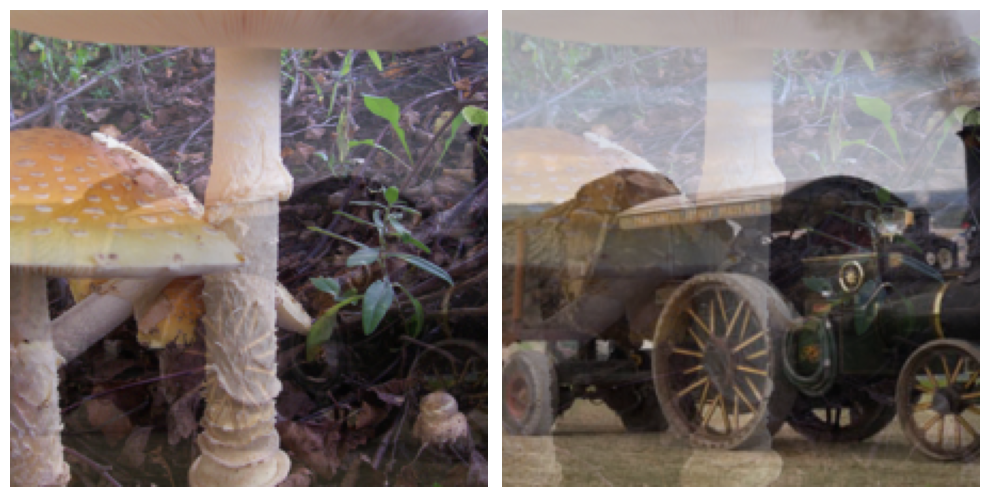

In [ ]:
## mixup
mixup_images = mixup(images.to(device))
sp = 'figs/mixup_images'
show_imagenet_images(mixup_images.cpu(),sp)

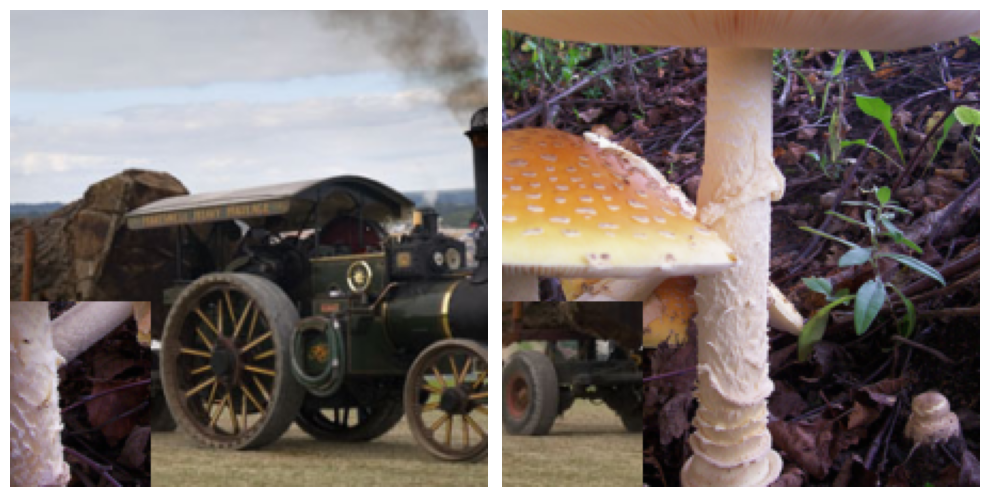

In [ ]:
## cutmix
cutmix_images = cutmix(images.to(device))
sp = 'figs/cutmix_images'
show_imagenet_images(cutmix_images.cpu(),sp)

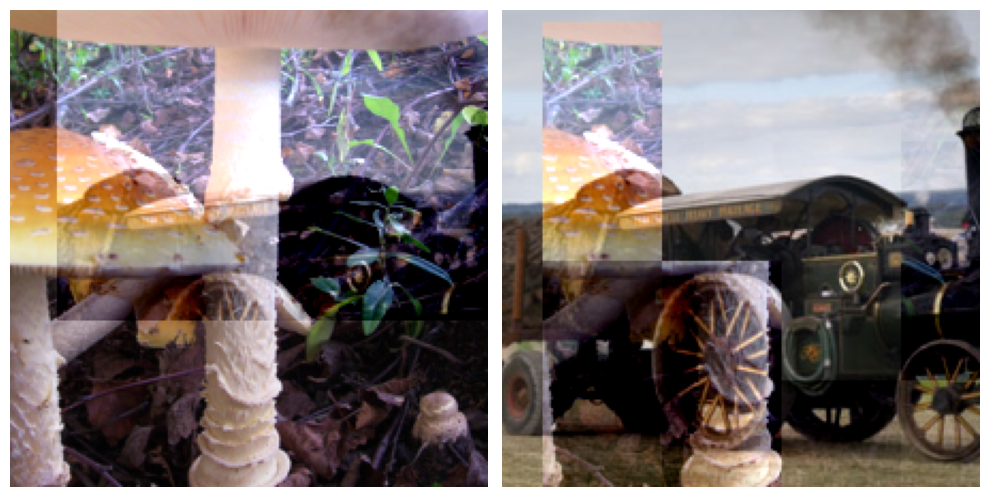

In [ ]:
## gridmix
def gridmix(image1, image2, S_max=5, kappa=0.5):
    C, H, W = image1.shape
    S = torch.randint(1, S_max + 1, (1,)).item()
    lambda_grid = torch.distributions.Beta(kappa, kappa).sample((S, S))
    h_offset = torch.empty(1).uniform_(-H/(2*S), H/(2*S)).item()
    w_offset = torch.empty(1).uniform_(-W/(2*S), W/(2*S)).item()
    y_coords = torch.linspace(0, H, S + 1) + h_offset
    x_coords = torch.linspace(0, W, S + 1) + w_offset
    mask = torch.zeros(H, W)
    for i in range(S):
        for j in range(S):
            y_start = max(0, int(y_coords[i].item()))
            y_end = min(H, int(y_coords[i + 1].item()))
            x_start = max(0, int(x_coords[j].item()))
            x_end = min(W, int(x_coords[j + 1].item()))
            if y_start >= y_end or x_start >= x_end:
                continue
            mask[y_start:y_end, x_start:x_end] = lambda_grid[i, j]
    mask = mask.unsqueeze(0)  # (1, H, W)
    mixed_image = mask * image1 + image2
    return mixed_image
gridmix_image1 = gridmix(images[0],images[1])
gridmix_image2 = gridmix(images[1],images[0])
gridmix_image = torch.cat([gridmix_image1.unsqueeze(0),gridmix_image2.unsqueeze(0)])
sp = 'figs/gridmix_image'
show_imagenet_images(gridmix_image.cpu(),sp)

